## Importing libraries and dependencies

In [1]:
!gsutil -m cp gs://dtire-special-storage/archive.zip .
!ls -l

Copying gs://dtire-special-storage/archive.zip...
/ [1/1 files][707.6 MiB/707.6 MiB] 100% Done   9.7 MiB/s ETA 00:00:00           
Operation completed over 1 objects/707.6 MiB.                                    
total 724612
-rw-r--r-- 1 root root 741994332 Jun  2 07:39 archive.zip
drwxr-xr-x 1 root root      4096 May 17 13:39 sample_data


In [2]:
!unzip -q archive.zip

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report

# HyperParameter


In [8]:
train_path='./Tire Textures/training_data'
test_path='./Tire Textures/testing_data'
EPOCHS=15
BATCH_SIZE=8
RANDOM_SEED=16

# Data visualization

In [9]:
labels=os.listdir(train_path)
labels

['normal', 'cracked']

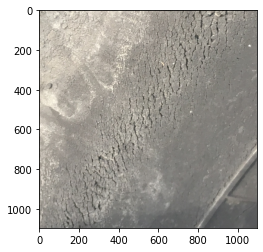

In [10]:
train_cracked=train_path+"/cracked/"
train_normal=train_path+"/normal/"

len(os.listdir(train_cracked))
random_num=np.random.randint(0,len(os.listdir(train_cracked)))
pic_path=os.listdir(train_cracked)[random_num]

img_path=train_cracked + pic_path
plt.imshow(plt.imread(img_path))

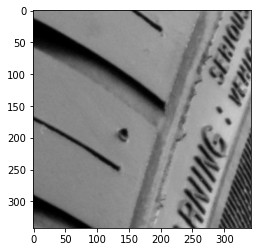

In [11]:
train_normal=train_path+"/normal/"
len(os.listdir(train_normal))
random_num=np.random.randint(0,len(os.listdir(train_normal)))
pic_path=os.listdir(train_normal)[random_num]

img_path=train_normal + pic_path
plt.imshow(plt.imread(img_path))

# Preparing our dataset

In [12]:
def process(data):
    path=Path(data) #get the path
    filepaths=list(path.glob(r"*/*.jpg")) # get all the subpath
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths)) #get the label for each subpath
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1) # concat the series of filepaths and label to be one dataframe
    return df

In [13]:
train=process(train_path)
test=process(test_path)

# merge the dataset
df_full = pd.concat([train, test], axis=0)
df_full = df_full.sample(frac=1, random_state=RANDOM_SEED)

# split the full dataset by 0.8/0.2 to train and test
sliceIdx= int(0.7*len(df_full))
df_train = df_full.iloc[:sliceIdx,:]
df_test_full = df_full.iloc[sliceIdx:,:]

# split the test dataset to val and test
sliceIdx= int(0.7*len(df_test_full))
df_val = df_test_full.iloc[:sliceIdx,:]
df_test = df_test_full.iloc[sliceIdx:,:]




print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

print(df_train['labels'].value_counts()['normal'])

(719, 2)
(216, 2)
(93, 2)
333


In [23]:
train_generator = ImageDataGenerator( preprocessing_function=preprocess_input, rotation_range = 10, zoom_range = 0.4, width_shift_range=0.1, horizontal_flip=True, )
val_generator = ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator( preprocessing_function=preprocess_input)

In [24]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(150,150),
                                                batch_size=BATCH_SIZE,                                               
                                                random_seed=RANDOM_SEED)

val_image=val_generator.flow_from_dataframe(dataframe=df_val,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(150,150),
                                                batch_size=BATCH_SIZE,  
                                                                                             
                                                random_seed=RANDOM_SEED)

test_image = test_generator.flow_from_dataframe(
                                                dataframe=df_test,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                shuffle=False,
                                                target_size=(150,150),
                                                batch_size=BATCH_SIZE,
)

Found 719 validated image filenames belonging to 2 classes.
Found 216 validated image filenames belonging to 2 classes.
Found 93 validated image filenames belonging to 2 classes.


# Model building

In [25]:
pretrained_model = ResNet50(
    input_shape=(150,150, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False #We don't want to train again the resnet



In [33]:
inputs = pretrained_model.input


x = Dense(64, activation='relu')(pretrained_model.output)
x = Dense(32, activation='relu')(pretrained_model.output)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)#adding some custom output layer base on need.
#output layer has 1 unit neuron for classify
outputs = Dense(1, activation='sigmoid')(x)


model = Model(inputs=inputs, outputs=outputs)

In [34]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Architecture

In [35]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

# Training

In [36]:
mo_fit=model.fit(train_image,
                 epochs=EPOCHS,
                 validation_data=val_image,
                 verbose = 1)

Epoch 1/15
90/90 [==============================] - 43s 442ms/step - loss: 0.6427 - accuracy: 0.7038 - val_loss: 0.5159 - val_accuracy: 0.7083
Epoch 2/15
90/90 [==============================] - 39s 437ms/step - loss: 0.4142 - accuracy: 0.8275 - val_loss: 0.2795 - val_accuracy: 0.8704
Epoch 3/15
90/90 [==============================] - 38s 427ms/step - loss: 0.3678 - accuracy: 0.8414 - val_loss: 0.2232 - val_accuracy: 0.8935
Epoch 4/15
90/90 [==============================] - 38s 423ms/step - loss: 0.3031 - accuracy: 0.8498 - val_loss: 0.2660 - val_accuracy: 0.8889
Epoch 5/15
90/90 [==============================] - 39s 435ms/step - loss: 0.2769 - accuracy: 0.8804 - val_loss: 0.2430 - val_accuracy: 0.9028
Epoch 6/15
90/90 [==============================] - 41s 458ms/step - loss: 0.2886 - accuracy: 0.8637 - val_loss: 0.2165 - val_accuracy: 0.9028
Epoch 7/15
90/90 [==============================] - 41s 461ms/step - loss: 0.2581 - accuracy: 0.8846 - val_loss: 0.1791 - val_accuracy: 0.9120

# Performance plots

No handles with labels found to put in legend.


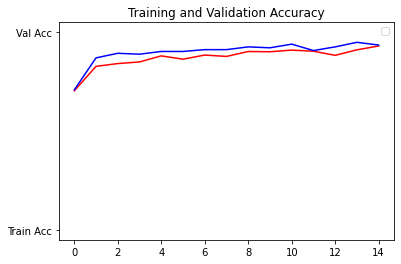

No handles with labels found to put in legend.


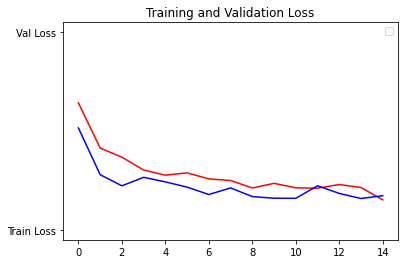

In [37]:
acc = mo_fit.history['accuracy']
val_acc = mo_fit.history['val_accuracy']
loss = mo_fit.history['loss']
val_loss = mo_fit.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', 'Train Acc')
plt.plot(epochs, val_acc, 'b', 'Val Acc')
plt.title("Training and Validation Accuracy")
plt.legend(loc=0)
plt.show()
print('')
plt.plot(epochs, loss, 'r', 'Train Loss')
plt.plot(epochs, val_loss, 'b', 'Val Loss')
plt.legend(loc=0)
plt.title("Training and Validation Loss")
plt.show()

# Evaluation on test set

In [38]:
model.evaluate(test_image)

12/12 [==============================] - 4s 289ms/step - loss: 0.1449 - accuracy: 0.9462


[0.14488305151462555, 0.9462365508079529]

In [39]:
test_pred = model.predict(test_image)
THRESHOLD = 0.5
test_pred_class = (test_pred >= THRESHOLD).reshape(-1,)

test_image_class = test_image.classes

pd.DataFrame(
    confusion_matrix(test_image_class, test_pred_class),
    index = [["actual", "actual"],["normal", "cracked"]],
    columns = [["predicted", "predicted"], ["normal","cracked"]]
)

predicted        
                  normal cracked
actual normal         42       1
       cracked         4      46

# Save the Model

In [40]:
model.save("saved_models/v1/")

INFO:tensorflow:Assets written to: saved_models/v1/assets


In [43]:
!zip -r model_v1.zip saved_models/v1

  adding: saved_models/v1/ (stored 0%)
  adding: saved_models/v1/assets/ (stored 0%)
  adding: saved_models/v1/keras_metadata.pb (deflated 95%)
  adding: saved_models/v1/variables/ (stored 0%)
  adding: saved_models/v1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_models/v1/variables/variables.index (deflated 80%)
  adding: saved_models/v1/saved_model.pb (deflated 92%)


Test with your arbitrary image

In [60]:

image_path = "test_cracked7.jpg"

img = tf.keras.utils.load_img(image_path, target_size=(150, 150), )
img_arr = tf.keras.utils.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = preprocess_input(img_arr)
np.set_printoptions(suppress=True)

model.predict(img_arr)

array([[0.00003056]], dtype=float32)